# K-Nearest Neighbours Regressor from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
2. [Loading Data](#2-loading-data)
3. [Data Preprocessing](#3-data-preprocessing)
    - [Dealing with Outliers](#dealing-with-outliers)
    - [Handling Categorical Features](#handling-categorical-features)
    - [Handling Continuous Features](#handling-continuous-features)
    - [Normalising After Encoding & Scaling Features](#normalising-after-encoding--scaling-features)
4. [Distance Calculation](#4-distance-calculation)
    - [Euclidean Distance](#euclidean-distance)
5. [Train Test Split](#5-train-test-split)
6. [Model Encapsulation](#6-model-encapsulation)
7. [Model Evaluation](#7-model-evaluation)
    - [Mean Squared Error (MSE)](#mean-squared-error-mse)
    - [Root Mean Squared Error (RMSE)](#root-mean-squared-error-rmse)
    - [Mean Absolute Error (MAE)](#mean-absolute-error-mae)
    - [R-Squared ($R^2$)](#r-squared)
8. [Comparison with Scikit-Learn](#8-comparison-with-scikit-learn)
***

## 1. Introduction
K-Nearest Neighbours (KNN) algorithm is a non-parametric supervised machine learning technique used for classification and regression. KNN predicts the class or value of a data point by calculating and analysing the distance from the data point to the $k$ closest neighbouring points in the training data. The algorithm uses a distance metric such as Euclidean, Manhattan, Chebyshev or Minkowski to identify the $k$ nearest neighbours and determines the predicted label or value based on a **majority vote** (for classification) or **averaging** (for regression).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from numpy.typing import NDArray
from tqdm import tqdm
from scipy.spatial.distance import cdist

## 2. Loading Data
Retrieved from [Kaggle - Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds)

**price**: Price in US dollars ($326 - $18,823)

**carat**: Weight of the diamond (0.2 - 5.01)

**cut**: Quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color**: Diamond colour, from J (worst) to D (best)

**clarity**: Measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x**: Length in mm (0 - 10.74)

**y**: Width in mm (0 - 58.9)

**z**: Depth in mm (0 - 31.8)

**depth**: Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)

**table**: Width of top of diamond relative to widest point (43--95)

In [2]:
df = pd.read_csv('../_datasets/diamonds.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

## 3. Data Preprocessing

### Dealing with Outliers
- Boxplot to identify numerical outliers.
- Winsorisation or capping to handle extreme values, if necessary.

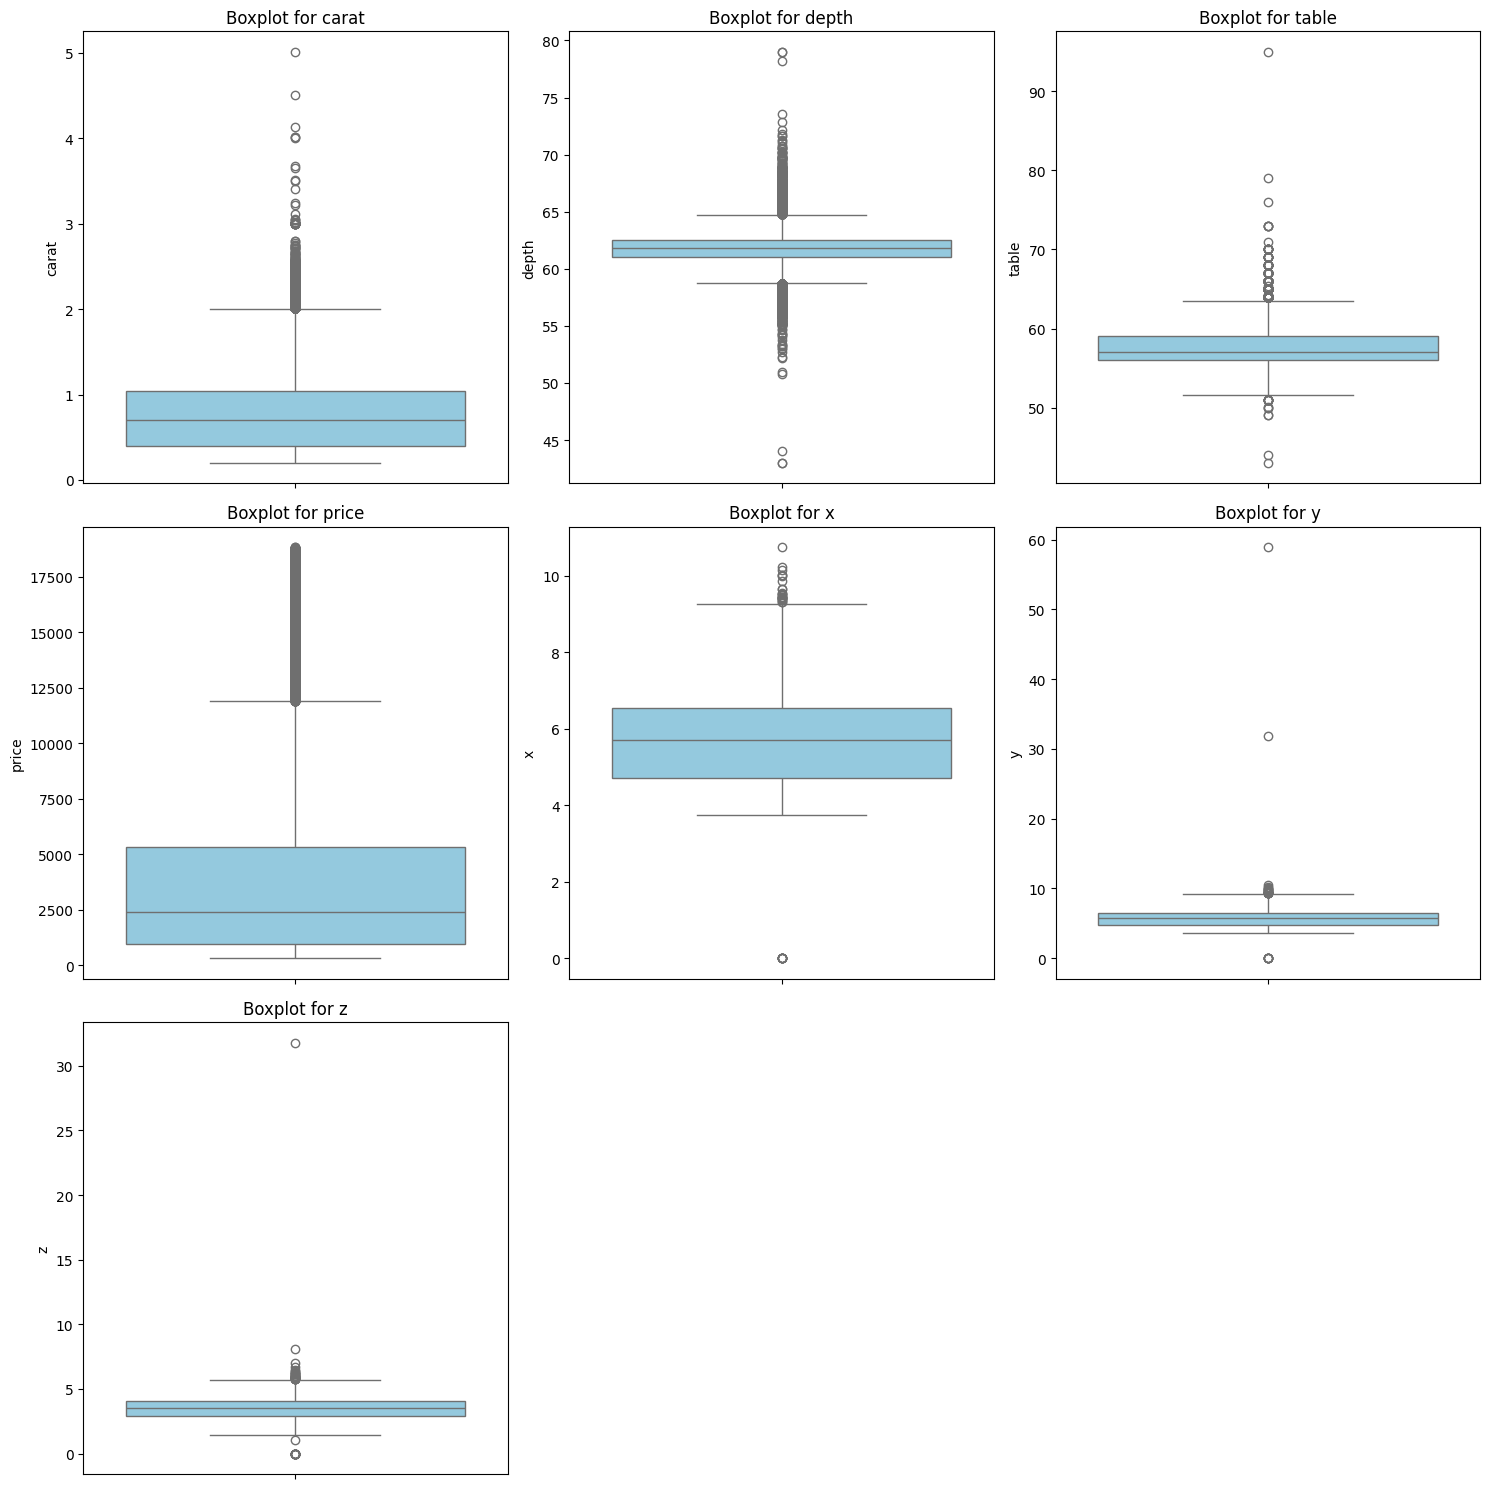

In [ ]:
def plot_boxplots(df: pd.DataFrame) -> None:
    """
    Generate boxplots for each numerical column in the dataset to visualise outliers.

    Args:
        df: The input dataframe.
    """
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_columns = len(numerical_columns)

    # Create subplots for boxplots
    fig, axes = plt.subplots(nrows=(num_columns + 2) // 3,
                             ncols=3, figsize=(15, 5 * ((num_columns + 2) // 3)))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, y=column, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot for {column}')
        axes[i].set_ylabel(column)
        axes[i].set_xlabel('')

    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_boxplots(df)

$Q1 =$ 25th percentile

$Q3 =$ 75th percentile

$IQR =$ Interquartile Range (50% at the middle) $= Q3 - Q1$

Lower bound $= Q1 - 1.5 \times IQR$

Upper bound $= Q3 + 1.5 \times IQR$

In [ ]:
def remove_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from all numerical columns in the dataframe using the IQR method.

    Args:
        df: The input dataframe.

    Returns:
        DataFrame with outliers removed from all numerical columns.
    """
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

        # Filter out rows with outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


# Call the function to remove outliers
df = remove_outliers_iqr(df)

### Handling Categorical Features
Encoding Categorical Features:
- **cut**: Ordinal encoding (Fair < Good < Very Good < Premium < Ideal).
- **color**: Ordinal encoding (J < I < H < G < F < E < D).
- **clarity**: Ordinal encoding (I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF).

In [ ]:
def ordinal_encode(data: NDArray[np.str_], levels: NDArray[np.str_]) -> NDArray[np.int64]:
    """
    Perform ordinal encoding for a categorical feature.

    Args:
        data: List of categorical values.
        levels: Ordered list of unique levels in the desired order.

    Returns:
        Ordinally encoded array.
    """
    level_map = {level: i for i, level in enumerate(levels)}
    return np.array([level_map[val] for val in data])

In [7]:
# Define categorical and continuous features
categorical_features = {
    'cut': ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
}

# Process categorical features
for feature, levels in categorical_features.items():
    df[feature] = ordinal_encode(df[feature], levels)
df[['cut', 'color', 'clarity']].head(10)

,cut,color,clarity
0,4,5,1
1,3,5,2
3,3,1,3
4,1,0,1
5,2,0,5
6,2,1,6
7,2,2,2
9,2,2,4
10,1,0,2
11,4,0,4


### Handling Continuous Features
Continuous features have varying ranges, and distance-based algorithms like KNN are sensitive to these differences.
- **price** (326 – 18,823): Standardise. Large range with potential outliers.
- **carat** (0.2 – 5.01): Standardise to handle outliers and maintain Gaussian-like distribution.
- **x, y, z** (0 – 10.74, 0 – 58.9, 0 – 31.8): Standardise. Widely different ranges and potential outliers.
- **depth** (43 – 79): Standardise as it’s a percentage, and differences might be subtle.
- **table** (43 – 95): Standardise for consistency across the dataset.

Standardisation centers data around the mean with unit variance, reducing the impact of outliers and differences in scale. This is suitable for KNN regression as it ensures fair weight across features in distance calculations. Standardisation transforms the data to have:

1. Mean = 0, which will become a centre value.
2. Standard Deviation = 1, making sure the spread of data is scaled.

The formula is:
\begin{align*}
z = \dfrac{x - \mu}{\sigma}
\end{align*}

where:

$x$: Original data value.

$\mu$: Mean of the feature.

$\sigma$: Standard deviation of the feature.

In [ ]:
def standardise(data: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Standardise the dataset.

    Args:
        data: A 2D NumPy array where each column is a feature.

    Returns:
        Standardised dataset with mean 0 and variance 1.
    """
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    return (data - data_mean) / data_std

In [9]:
continuous_features = ['carat', 'x', 'y', 'z',
                       'depth', 'table', 'cut', 'color', 'clarity']
df[continuous_features] = standardise(df[continuous_features].values)

### Normalising After Encoding & Scaling Features
If the final dataset contains a mix of scaled and encoded features, normalise the final feature matrix to make sure all features fall within a similar range for better distance calculation. The equation for min-max normalisation is:

\begin{align*}
x_{normalised} = \dfrac{x - min(X)}{max(X) - min(X)}
\end{align*}

In [ ]:
def normalise(data: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Normalise the dataset to range [0, 1].

    Args:
        data: A 2D NumPy array where each column is a feature.

    Returns:
        Normalised dataset.
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val)


df[continuous_features] = normalise(df[continuous_features].values)
df[continuous_features]

,carat,x,y,z,depth,table,cut,color,clarity
0,0.016667,0.048458,0.065359,0.277929,0.446429,0.260870,1.00,0.833333,0.142857
1,0.005556,0.035242,0.034858,0.245232,0.142857,0.782609,0.75,0.833333,0.285714
3,0.050000,0.103524,0.119826,0.332425,0.607143,0.521739,0.75,0.166667,0.428571
4,0.061111,0.134361,0.145969,0.365123,0.767857,0.521739,0.25,0.000000,0.142857
5,0.022222,0.046256,0.061002,0.291553,0.678571,0.434783,0.50,0.000000,0.714286
...,...,...,...,...,...,...,...,...,...
53935,0.288889,0.444934,0.453159,0.569482,0.321429,0.434783,1.00,1.000000,0.285714
53936,0.288889,0.431718,0.450980,0.599455,0.732143,0.260870,0.25,1.000000,0.285714
53937,0.277778,0.425110,0.435730,0.585831,0.678571,0.695652,0.50,1.000000,0.285714
53938,0.366667,0.533040,0.531590,0.634877,0.357143,0.521739,0.75,0.333333,0.142857


## 4. Distance Calculation
### Euclidean Distance
Euclidean distance is the most widely used distance metric in KNN algorithms, which measures the shortest distance between two points as a straight line in multi-dimensional space.

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}

In [11]:
# Calculate Eucliean Distance
def calculate_euclidean(a: float, b: float) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

## 5. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.

In [ ]:
def train_test_split(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2,
                     random_state: int = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split arrays or matrices into random train and test subsets.

    Args:
        X: Input features, a 2D array with rows (samples) and columns (features).
        y: Target values/labels, a 1D array with rows (samples).
        test_size: Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state: Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        A tuple containing:
            - X_train: Training set features.
            - X_test: Testing set features.
            - y_train: Training set target values.
            - y_test: Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: NDArray[np.int64] = indices[:test_size]
    train_indices: NDArray[np.int64] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

## 6. Model Encapsulation

In [ ]:
class CustomKNNRegressor:
    """
    A simple K-Nearest Neighbours (KNN) regressor.
    """

    def __init__(self, k: int = 3) -> None:
        """
        Initialise the model with k, the number of neighbours.

        Args: 
            k: The number of nearest neighbours to consider for classification. default = 3.
        """
        self.k = k

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        """
        Fit the training data.

        Args:
            X_train: Training features, pd.DataFrame with rows (samples) and columns (features).
            y_train: Training labels, pd.Series of labels corresponding to X_train.
        """
        self.X_train = X_train.values
        self.y_train = y_train.values

    def predict(self, X_test: pd.DataFrame) -> NDArray[np.float64]:
        """
        Predict the labels for X_test.

        Args:
            X_test: Test features, a 2D array with rows (samples) and columns (features).

        Returns:
            Predicted target values for each test sample.
        """

        # Ensure input is 2D
        if X_test.ndim == 1:
            X_test = X_test.reshape(1, -1)

        # Compute distances
        # ! Use scipy library for faster computation of Euclidean distance
        distances = cdist(X_test, self.X_train, metric='euclidean')

        # Find indices of k nearest neighbours for each test sample
        idx = np.argpartition(distances, kth=self.k-1, axis=1)[:, :self.k]

        # Gather the corresponding y_train values and compute their mean
        predictions = np.mean(self.y_train[idx], axis=1)
        return predictions

## 7. Model Evaluation


### Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{n} \sum_{i=1}^{n}(\hat y_{i} = y_{i})^2
\end{align*}


In [14]:
def calculate_MSE(y_true: pd.Series, y_pred: NDArray[np.float64]) -> float:
    return np.mean((y_true - y_pred) ** 2)

### Root Mean Squared Error (RMSE)
Square root of MSE. It provides error in the same unit as the target variable ($y$) and easier to interpret.

\begin{align*}
RMSE = \sqrt{(MSE)}
\end{align*}

In [15]:
def calculate_RMSE(y_true: pd.Series, y_pred: NDArray[np.float64]) -> float:
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

### Mean Absolute Error (MAE)
Mean Absolute Error measures the average absolute difference between predicted ($\hat y$) and actual ($y$) values. It is less sensitive to outliers than MSE. Smaller MAE indicates better predictions.

\begin{align*}
MAE = \dfrac{1}{n} \sum_{i=1}^{n}|\hat y_{i} = y_{i}|
\end{align*}

In [16]:
def calculate_MAE(y_true: pd.Series, y_pred: NDArray[np.float64]) -> float:
    return np.mean(np.abs(y_true - y_pred))

<a id="r-squared"></a>
### R-Squared($R^2$)

R-squared indicated the proportion of variance in the dependent variable that is predictable from the independent variables. Value ranges from 0 to 1. Closer to 1 indicates a better fit.



Residual Sum of Squares ($SS_{residual}$): 
\begin{align*}
SS_{residual} = \sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}
\end{align*}

Total Sum of Squares ($SS_{total}$): 
\begin{align*}
SS_{total} = \sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}
\end{align*}

$R^2$ is computed as:

\begin{align*}

R^2 = 1 - \dfrac{SS_{residual}}{SS_{total}} = 1 - \dfrac{\sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}}{\sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}}

\end{align*}

where:

$y$: Actual target values.

$\bar y$: Mean of the actual target values.

$\hat y$: Precicted target values.

In [17]:
def calculate_r2(y_true: pd.Series, y_pred: NDArray[np.float64]) -> float:
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [ ]:
def evaluate(y_true: pd.Series, y_pred: NDArray[np.float64]) -> Tuple[float, float, float, float]:
    """
    Calculate and return evaluation metrics for a regression model, including MSE, RMSE, MAE, and R-squared.

    Args:
        y_true : True target values.
        y_pred: Predicted target values.

    Returns:
        - mse: Mean Squared Error (MSE), indicating the average of the squared differences between predicted and true values.
        - rmse: Root Mean Squared Error (RMSE), indicating the standard deviation of the residuals.
        - mae: Mean Absolute Error (MAE), representing the average absolute difference between predicted and true values.
        - r2: R-squared (coefficient of determination), showing the proportion of variance in the dependent variable that is predictable from the independent variable(s).
    """
    mse = calculate_MSE(y_true, y_pred)
    rmse = calculate_RMSE(y_true, y_pred)
    mae = calculate_MAE(y_true, y_pred)
    r2 = calculate_r2(y_true, y_pred)
    return mse, rmse, mae, r2

Let's make predictions using the KNN regressor and evaluate the model's performance with different `k` values ranging from 1 to 20. 

In [19]:
MSE_list_custom, RMSE_list_custom, MAE_list_custom, R2_list_custom = [], [], [], []
X = df.drop(columns=['price'])
y = df['price']
k_range = range(1, 21)  # Generate k-values from 1 to 20

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train KNN regressor, make predictions and evaluate the model for different k values.
for k in tqdm(k_range):
    knn_reg = CustomKNNRegressor(k=k)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)

    mse_custom, rmse_custom, mae_custom, r2_custom = evaluate(y_test, y_pred)
    print(f"For k = {k}, MSE: {mse_custom}")
    print(f"For k = {k}, RMSE: {rmse_custom}")
    print(f"For k = {k}, MAE: {mae_custom}")
    print(f"For k = {k}, R2: {r2_custom}")
    print("-----------")
    MSE_list_custom.append(mse_custom)
    RMSE_list_custom.append(rmse_custom)
    MAE_list_custom.append(mae_custom)
    R2_list_custom.append(r2_custom)

  5%|▌         | 1/20 [00:03<01:13,  3.85s/it]

For k = 1, MSE: 298714.20105308405
For k = 1, RMSE: 546.5475286313937
For k = 1, MAE: 309.49075865033313
For k = 1, R2: 0.9556486536624663
-----------


 10%|█         | 2/20 [00:07<01:04,  3.59s/it]

For k = 2, MSE: 240137.25169245648
For k = 2, RMSE: 490.0380104567976
For k = 2, MAE: 284.746776273372
For k = 2, R2: 0.9643458182409514
-----------


 15%|█▌        | 3/20 [00:10<01:01,  3.61s/it]

For k = 3, MSE: 219599.7442629606
For k = 3, RMSE: 468.6147076895481
For k = 3, MAE: 274.04437996991186
For k = 3, R2: 0.9673951078351658
-----------


 20%|██        | 4/20 [00:17<01:19,  4.96s/it]

For k = 4, MSE: 209304.76005399742
For k = 4, RMSE: 457.49837164081515
For k = 4, MAE: 268.63923812594027
For k = 4, R2: 0.9689236471834174
-----------


 25%|██▌       | 5/20 [00:24<01:25,  5.68s/it]

For k = 5, MSE: 205813.82195142918
For k = 5, RMSE: 453.6670827285458
For k = 5, MAE: 266.8022995916613
For k = 5, R2: 0.9694419613589205
-----------


 30%|███       | 6/20 [00:31<01:25,  6.13s/it]

For k = 6, MSE: 205029.19210724265
For k = 6, RMSE: 452.8014930488223
For k = 6, MAE: 266.66818898201876
For k = 6, R2: 0.9695584586323799
-----------


 35%|███▌      | 7/20 [00:38<01:23,  6.41s/it]

For k = 7, MSE: 204023.47837471546
For k = 7, RMSE: 451.68958187533553
For k = 7, MAE: 265.1321727917473
For k = 7, R2: 0.9697077811550804
-----------


 40%|████      | 8/20 [00:45<01:19,  6.64s/it]

For k = 8, MSE: 203625.01292512895
For k = 8, RMSE: 451.24828301626695
For k = 8, MAE: 264.3628841607565
For k = 8, R2: 0.969766942986342
-----------


 45%|████▌     | 9/20 [00:52<01:14,  6.74s/it]

For k = 9, MSE: 203553.31451897486
For k = 9, RMSE: 451.16883150210504
For k = 9, MAE: 264.7386154691119
For k = 9, R2: 0.9697775883484707
-----------


 50%|█████     | 10/20 [00:59<01:08,  6.80s/it]

For k = 10, MSE: 204608.8792488717
For k = 10, RMSE: 452.3371300798462
For k = 10, MAE: 265.7672576832151
For k = 10, R2: 0.9696208642397665
-----------


 55%|█████▌    | 11/20 [01:06<01:01,  6.86s/it]

For k = 11, MSE: 203100.07906211758
For k = 11, RMSE: 450.66626128668383
For k = 11, MAE: 265.38968016724306
For k = 11, R2: 0.9698448821117022
-----------


 60%|██████    | 12/20 [01:13<00:55,  6.91s/it]

For k = 12, MSE: 204767.6315049132
For k = 12, RMSE: 452.51257607376306
For k = 12, MAE: 266.47959201948566
For k = 12, R2: 0.9695972936285778
-----------


 65%|██████▌   | 13/20 [01:20<00:48,  6.92s/it]

For k = 13, MSE: 203051.8692031736
For k = 13, RMSE: 450.61277079458546
For k = 13, MAE: 265.59703417150223
For k = 13, R2: 0.9698520400310222
-----------


 70%|███████   | 14/20 [01:27<00:41,  6.95s/it]

For k = 14, MSE: 203437.60873388685
For k = 14, RMSE: 451.0405843534336
For k = 14, MAE: 266.4262687666943
For k = 14, R2: 0.969794767670142
-----------


 75%|███████▌  | 15/20 [01:35<00:35,  7.01s/it]

For k = 15, MSE: 204410.95535449055
For k = 15, RMSE: 452.1182979646926
For k = 15, MAE: 266.88835160111756
For k = 15, R2: 0.9696502508278739
-----------


 80%|████████  | 16/20 [01:42<00:28,  7.01s/it]

For k = 16, MSE: 205121.05385596323
For k = 16, RMSE: 452.90291879823786
For k = 16, MAE: 266.95323581560285
For k = 16, R2: 0.9695448195344786
-----------


 85%|████████▌ | 17/20 [01:48<00:20,  7.00s/it]

For k = 17, MSE: 205933.20177442543
For k = 17, RMSE: 453.7986357123889
For k = 17, MAE: 267.6257253384913
For k = 17, R2: 0.96942423653748
-----------


 90%|█████████ | 18/20 [01:56<00:14,  7.01s/it]

For k = 18, MSE: 206886.5043231766
For k = 18, RMSE: 454.84778148648434
For k = 18, MAE: 268.17918547173866
For k = 18, R2: 0.9692826957223628
-----------


 95%|█████████▌| 19/20 [02:03<00:07,  7.02s/it]

For k = 19, MSE: 208580.9374439271
For k = 19, RMSE: 456.70662075771037
For k = 19, MAE: 269.11484950286746
For k = 19, R2: 0.969031116152596
-----------


100%|██████████| 20/20 [02:10<00:00,  6.51s/it]

For k = 20, MSE: 209286.28611352888
For k = 20, RMSE: 457.4781810245478
For k = 20, MAE: 269.8188749194069
For k = 20, R2: 0.9689263900865973
-----------


In [20]:
x_single_2d = X_test.iloc[0]

y_pred = knn_reg.predict(x_single_2d.values)
y_pred_scalar = y_pred[0]
print("Predicted value:", y_pred_scalar)

Predicted value: 3447.7


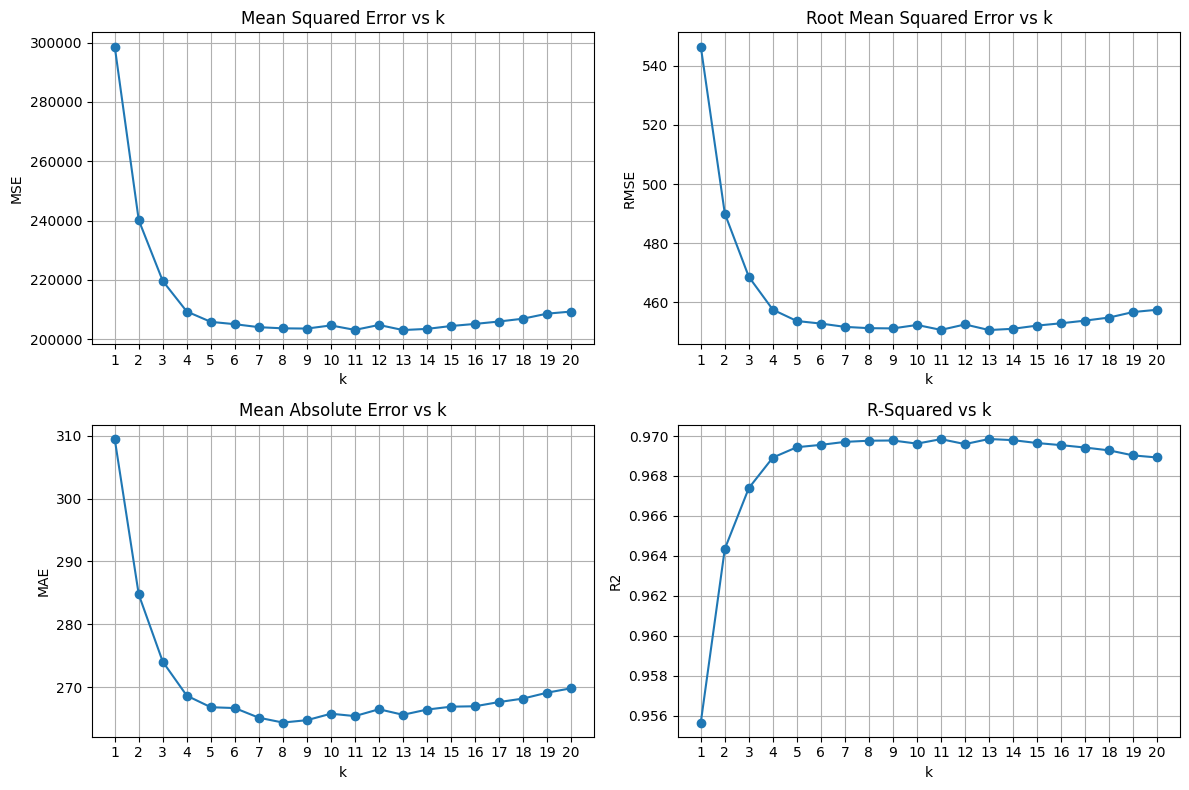

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

# MSE
axes[0][0].plot(k_range, MSE_list_custom, marker='o')
axes[0][0].set_title('Mean Squared Error vs k')
axes[0][0].set_xticks(k_range)
axes[0][0].set_xlabel('k')
axes[0][0].set_ylabel('MSE')
axes[0][0].grid(True)

# RMSE
axes[0][1].plot(k_range, RMSE_list_custom, marker='o')
axes[0][1].set_title('Root Mean Squared Error vs k')
axes[0][1].set_xticks(k_range)
axes[0][1].set_xlabel('k')
axes[0][1].set_ylabel('RMSE')
axes[0][1].grid(True)

# MAE
axes[1][0].plot(k_range, MAE_list_custom, marker='o')
axes[1][0].set_title('Mean Absolute Error vs k')
axes[1][0].set_xticks(k_range)
axes[1][0].set_xlabel('k')
axes[1][0].set_ylabel('MAE')
axes[1][0].grid(True)

# R2
axes[1][1].plot(k_range, R2_list_custom, marker='o')
axes[1][1].set_title('R-Squared vs k')
axes[1][1].set_xticks(k_range)
axes[1][1].set_xlabel('k')
axes[1][1].set_ylabel('R2')
axes[1][1].grid(True)
plt.tight_layout()
plt.show()

After conducting evaluations across all `k` values from 1 to 20, our analysis reveals that `k = 11` produces the most favourable results overall. This configuration achieves an MSE of 203106.14, RMSE of 450.67, MAE of 265.39, and an R-squared value of 0.9698 among the tested hyperparameters.

While `k = 13` shows marginally better MSE and RMSE values, `k = 11` offers superior generalisation with excellent predictive accuracy and represents the optimal balance between model complexity and performance. The minimal performance difference between `k = 11` and `k = 13` (less than 0.03% in MSE) suggests that `k = 11` provides the best trade-off between bias and variance while avoiding potential overfitting concerns.

***
1. Low k:

The model captures individual neighbours' values, resulting in predictions that closely match the actual values. This leads to very low errors (MSE and RMSE).
However, such models are prone to overfitting as they may also capture noise in the data.

2. High k:

The model averages the target values of more neighbours. While this smoothens the predictions and reduces overfitting, it also leads to underfitting, especially when the data has local variations.

As k increases further, the model loses its ability to adapt to smaller-scale patterns, resulting in larger prediction errors and increasing MSE and RMSE.

3. Extreme Case (k = n):

If k equals the total number of data points, the prediction will be the same for all test points (the average target value of the dataset). This causes maximum underfitting and leads to higher errors.

## 8. Comparison with Scikit-Learn

For k = 1, MSE: 298619.962389856
For k = 1, RMSE: 546.4613091426107
For k = 1, MAE: 309.46679561573177
For k = 1, R2: 0.9556626456708023
-----------
For k = 2, MSE: 240113.19632495166
For k = 2, RMSE: 490.013465452687
For k = 2, MAE: 284.67988394584137
For k = 2, R2: 0.964349389841939
-----------
For k = 3, MSE: 219590.38677555698
For k = 3, RMSE: 468.60472338161185
For k = 3, MAE: 274.0311626907372
For k = 3, R2: 0.9673964971804437
-----------
For k = 4, MSE: 209318.32693960884
For k = 4, RMSE: 457.51319865071525
For k = 4, MAE: 268.6651622609069
For k = 4, R2: 0.9689216328511883
-----------
For k = 5, MSE: 205814.10169782938
For k = 5, RMSE: 453.66739104527824
For k = 5, MAE: 266.80073071136894
For k = 5, R2: 0.9694419198238029
-----------
For k = 6, MSE: 205033.1376710366
For k = 6, RMSE: 452.8058498639749
For k = 6, MAE: 266.670427681066
For k = 6, R2: 0.9695578728180272
-----------
For k = 7, MSE: 204026.67064478918
For k = 7, RMSE: 451.693115560542
For k = 7, MAE: 265.12078229099

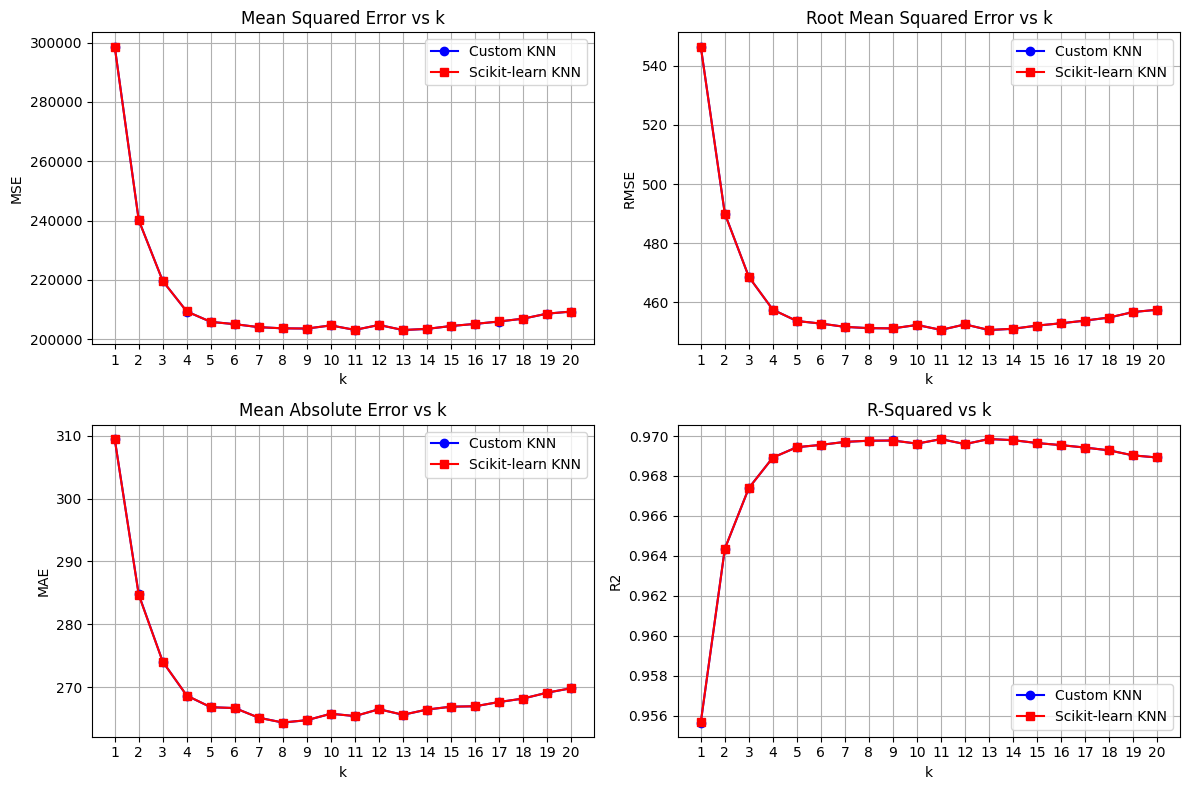

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

MSE_list_sk, RMSE_list_sk, MAE_list_sk, R2_list_sk = [], [], [], []
for k in k_range:
    # 'metric' is set to "minkowski", so p=1 for Manhattan and p=2 for Euclidean
    clf = KNeighborsRegressor(n_neighbors=k, p=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = clf.score(X_test, y_test)

    print(f"For k = {k}, MSE: {mse}")
    print(f"For k = {k}, RMSE: {rmse}")
    print(f"For k = {k}, MAE: {mae}")
    print(f"For k = {k}, R2: {r2}")
    print("-----------")

    # Append to lists
    MSE_list_sk.append(mse)
    RMSE_list_sk.append(rmse)
    MAE_list_sk.append(mae)
    R2_list_sk.append(r2)

# Plot metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# MSE
axes[0][0].plot(k_range, MSE_list_custom, marker='o',
                color='blue', label='Custom KNN')
axes[0][0].plot(k_range, MSE_list_sk, marker='s',
                color='red', label='Scikit-learn KNN')
axes[0][0].set_title('Mean Squared Error vs k')
axes[0][0].set_xlabel('k')
axes[0][0].set_ylabel('MSE')
axes[0][0].grid(True)
axes[0][0].legend()
axes[0][0].set_xticks(k_range)

# RMSE
axes[0][1].plot(k_range, RMSE_list_custom, marker='o',
                color='blue', label='Custom KNN')
axes[0][1].plot(k_range, RMSE_list_sk, marker='s',
                color='red', label='Scikit-learn KNN')
axes[0][1].set_title('Root Mean Squared Error vs k')
axes[0][1].set_xlabel('k')
axes[0][1].set_ylabel('RMSE')
axes[0][1].grid(True)
axes[0][1].legend()
axes[0][1].set_xticks(k_range)

# MAE
axes[1][0].plot(k_range, MAE_list_custom, marker='o',
                color='blue', label='Custom KNN')
axes[1][0].plot(k_range, MAE_list_sk, marker='s',
                color='red', label='Scikit-learn KNN')
axes[1][0].set_title('Mean Absolute Error vs k')
axes[1][0].set_xlabel('k')
axes[1][0].set_ylabel('MAE')
axes[1][0].grid(True)
axes[1][0].legend()
axes[1][0].set_xticks(k_range)

# R^2
axes[1][1].plot(k_range, R2_list_custom, marker='o',
                color='blue', label='Custom KNN')
axes[1][1].plot(k_range, R2_list_sk, marker='s',
                color='red', label='Scikit-learn KNN')
axes[1][1].set_title('R-Squared vs k')
axes[1][1].set_xlabel('k')
axes[1][1].set_ylabel('R2')
axes[1][1].grid(True)
axes[1][1].legend()
axes[1][1].set_xticks(k_range)

plt.tight_layout()
plt.show()

The scikit-learn implementation is working correctly and shows nearly identical performance to my custom model. The red lines representing the scikit-learn KNN results overlap the blue lines so closely that they are barely visible, demonstrating the similarity in performance between the two implementations.

In [23]:
MSE_diff = np.mean(np.abs(np.array(MSE_list_custom) - np.array(MSE_list_sk)))
MSE_percentage_diff = (MSE_diff / np.mean(MSE_list_sk)) * 100

RMSE_diff = np.mean(
    np.abs(np.array(RMSE_list_custom) - np.array(RMSE_list_sk)))
RMSE_percentage_diff = (RMSE_diff / np.mean(RMSE_list_sk)) * 100

MAE_diff = np.mean(np.abs(np.array(MAE_list_custom) - np.array(MAE_list_sk)))
MAE_percentage_diff = (MAE_diff / np.mean(MAE_list_sk)) * 100

R2_diff = np.mean(np.abs(np.array(R2_list_custom) - np.array(R2_list_sk)))
R2_percentage_diff = (R2_diff / np.mean(R2_list_sk)) * 100

print(
    f"The mean absolute difference of MSE between Custom KNN and Scikit-learn is: {MSE_diff:.2f}")
print(f"The mean percentage difference is: {MSE_percentage_diff:.4f}%")
print('----------')
print(
    f"The mean absolute difference of RMSE between Custom KNN and Scikit-learn is: {RMSE_diff:.2f}")
print(f"The mean percentage difference is: {RMSE_percentage_diff:.4f}%")
print('----------')
print(
    f"The mean absolute difference of MAE between Custom KNN and Scikit-learn is: {MAE_diff:.2f}")
print(f"The mean percentage difference is: {MAE_percentage_diff:.4f}%")
print('----------')
print(
    f"The mean absolute difference of R-Squared between Custom KNN and Scikit-learn is: {R2_diff:.2f}")
print(f"The mean percentage difference is: {R2_percentage_diff:.4f}%")

The mean absolute difference of MSE between Custom KNN and Scikit-learn is: 9.78
The mean percentage difference is: 0.0046%
----------
The mean absolute difference of RMSE between Custom KNN and Scikit-learn is: 0.01
The mean percentage difference is: 0.0021%
----------
The mean absolute difference of MAE between Custom KNN and Scikit-learn is: 0.01
The mean percentage difference is: 0.0036%
----------
The mean absolute difference of R-Squared between Custom KNN and Scikit-learn is: 0.00
The mean percentage difference is: 0.0001%
